In [1]:
# imports

import pandas as pd
import numpy as np
import pylab
import calendar
import seaborn as sns
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read file

data = pd.read_csv("../train.csv")

In [3]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


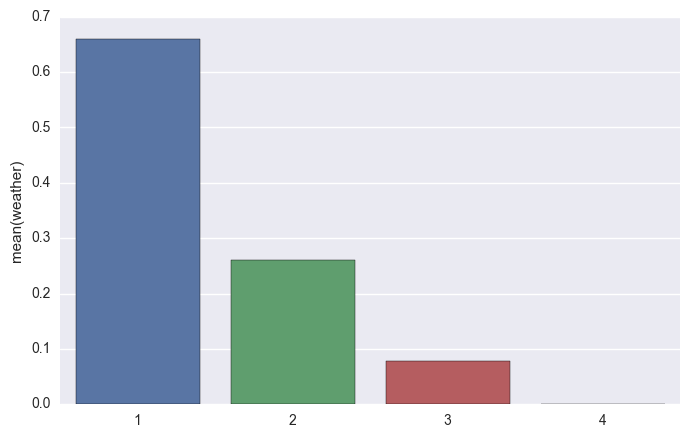

In [4]:
# data['weather'].value_counts().plot(kind='bar');

plt.figure(figsize=(8, 5))
sns.barplot(x = data['weather'].value_counts().index, y = data['weather'].value_counts(normalize = True));

We see that weather #1 ("Clear, Few clouds, Partly cloudy, Partly cloudy") accounts for more records than the remaining three weather types combined. 

In [5]:
# feature engineering

data['date'] = data.datetime.apply(lambda x : x.split()[0])
data['hour'] = data.datetime.apply(lambda x : x.split()[1].split(":")[0])
data['weekDay'] = data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
data['month'] = data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
data['season'] = data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })

# dropping unecessary fileds

data  = data.drop(["datetime","atemp"],axis=1)

In [6]:
data.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,casual,registered,count,date,hour,weekDay,month
0,Spring,0,0,1,9.84,81,0.0,3,13,16,2011-01-01,00,Saturday,January
1,Spring,0,0,1,9.02,80,0.0,8,32,40,2011-01-01,01,Saturday,January
2,Spring,0,0,1,9.02,80,0.0,5,27,32,2011-01-01,02,Saturday,January
3,Spring,0,0,1,9.84,75,0.0,3,10,13,2011-01-01,03,Saturday,January
4,Spring,0,0,1,9.84,75,0.0,0,1,1,2011-01-01,04,Saturday,January


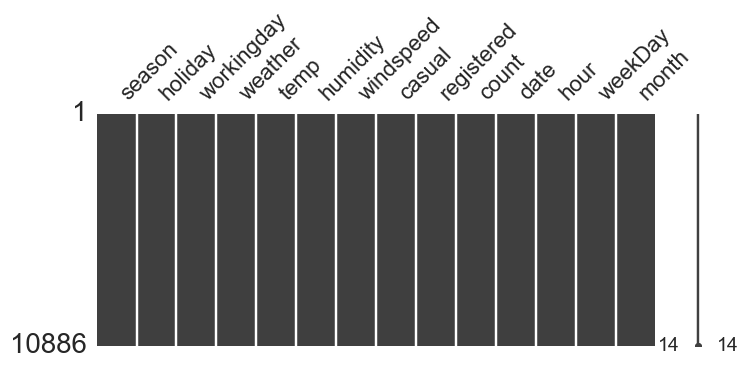

In [7]:
msno.matrix(data,figsize=(8,3))

We can see that each of the fourteen variables is essentially complete over time. No massive gaps in data to fill.

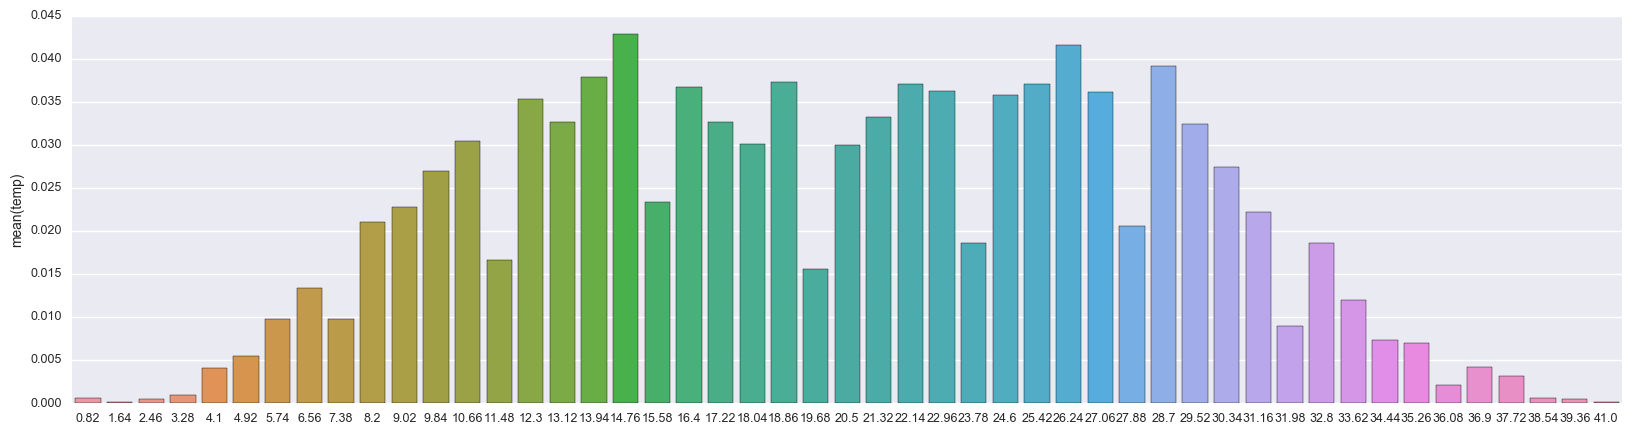

In [8]:
plt.figure(figsize=(20, 5))
sns.set(font_scale = 0.9)
sns.barplot(x = data['temp'].value_counts().index, y = data['temp'].sort_values(ascending = True).value_counts(normalize = True));

Temp shows a central tendency, somewhat normal distribution.

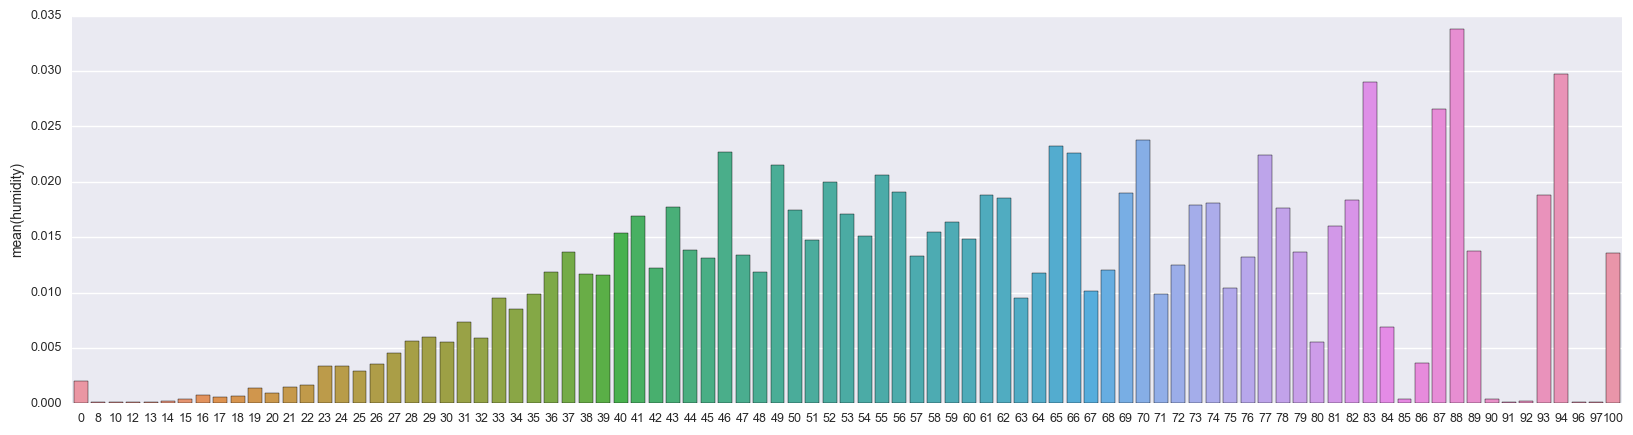

In [9]:
plt.figure(figsize=(20, 5))
sns.set(font_scale = 0.9)
sns.barplot(x = data['humidity'].value_counts().index, y = data['humidity'].sort_values(ascending = True).value_counts(normalize = True));

Rider counts are relatively evenly distributed between 40 and 79 with some interesting outliers occurring in the high 80's and low 90's, this would suggest an association with higher temps and ridership.

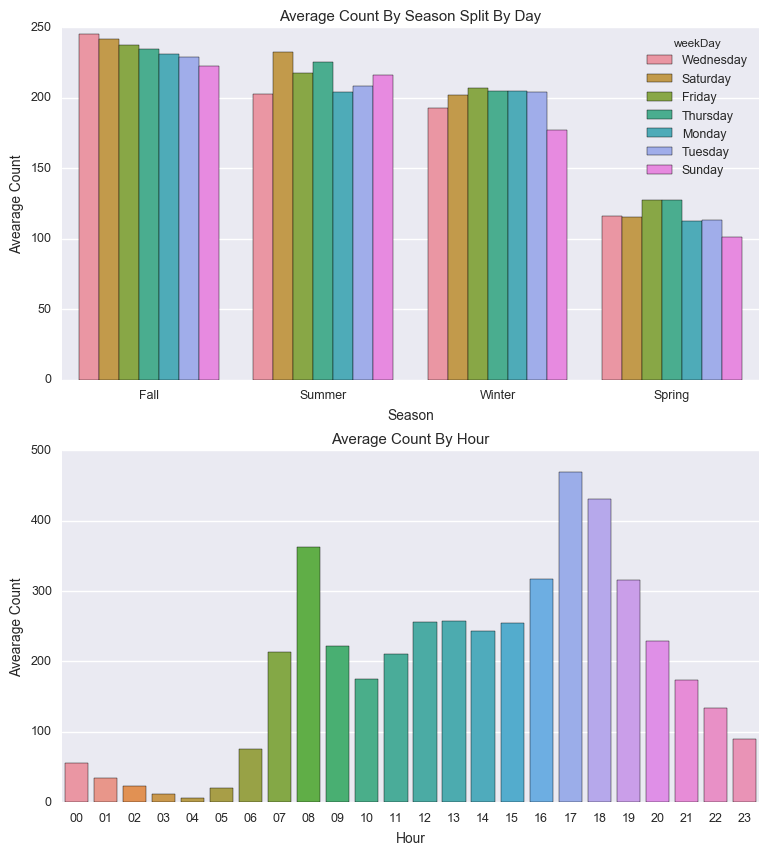

In [10]:
# demand for bicycle across month

fig,(ax1,ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(9, 10)

daySeasonAgg = pd.DataFrame(data.groupby(["season", "weekDay"], sort = True)["count"].mean()).reset_index().sort_values(by = ["count"], ascending = False)
sns.barplot(data = daySeasonAgg, x = "season", y = "count", hue = "weekDay", ax = ax1)
ax1.set(xlabel = 'Season', ylabel = 'Avearage Count', title = "Average Count By Season Split By Day");

hourAgg = pd.DataFrame(data.groupby("hour")["count"].mean()).reset_index().sort_values(by = "count", ascending = False)
sns.barplot(data = hourAgg, x = "hour", y = "count", ax = ax2)
ax2.set(xlabel = 'Hour', ylabel = 'Avearage Count', title = "Average Count By Hour");



Fall has the highest mean average rental counts for all seven days of the week compared to spring, summer, and winter.

Not surprisingly, there's a surge during 08 hour morning commute and again during the 17 and 18 hours evening commute.

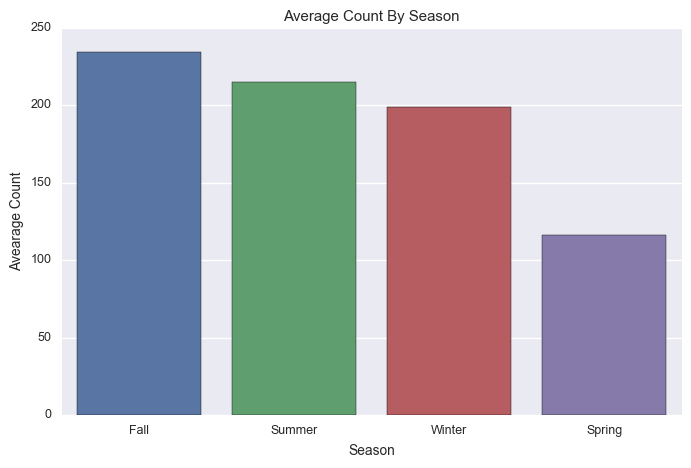

In [11]:
fig,(ax1)= plt.subplots(nrows = 1)
fig.set_size_inches(8, 5)

monthAggregated = pd.DataFrame(data.groupby("season")["count"].mean()).reset_index().sort_values(by = "count", ascending = False)
sns.barplot(data = monthAggregated, x = "season", y = "count", ax = ax1)
ax1.set(xlabel = 'Season', ylabel = 'Avearage Count', title = "Average Count By Season");

Not surprisingly given our week day by season chart, Fall has the higher mean relative to summer, winiter, and spring.

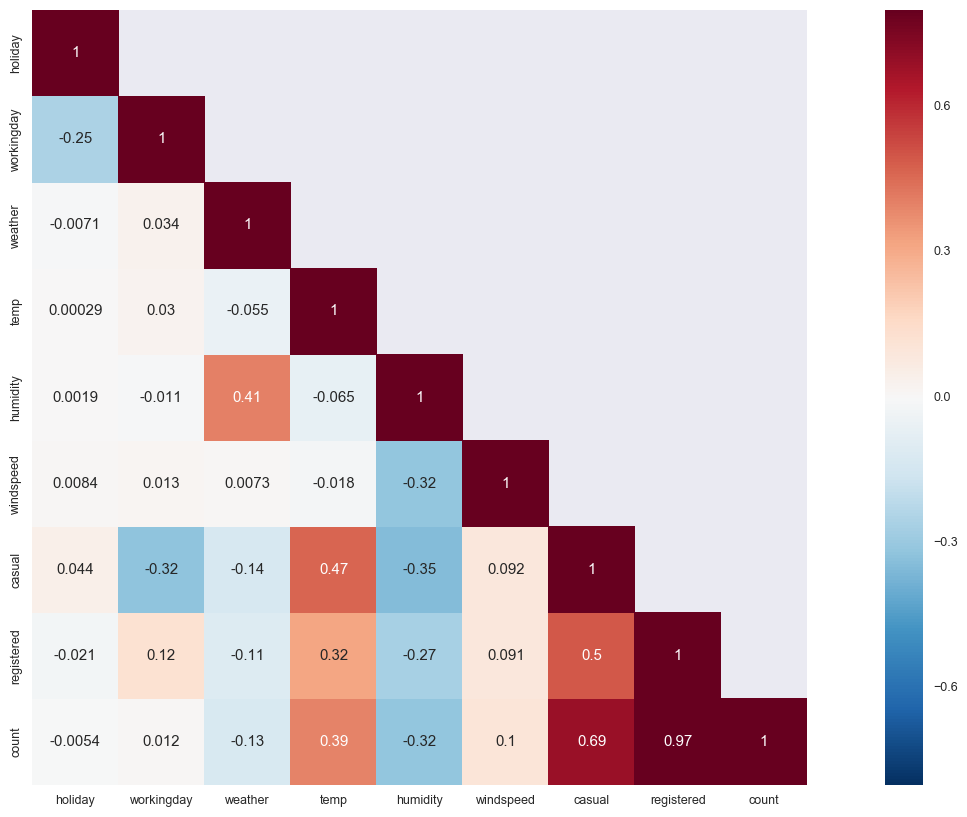

In [13]:
cm = data.corr()
mask = np.array(cm)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(cm, mask=mask,vmax=.8, square=True,annot=True);

We see an interesting relationship between 'casual' and 'temp', potentially aligning with our hypothesis that there's a strong relationship between the two factors. Similarly, although to a lesser degree, we see somewhat of a positive association between 'registered' and 'temp' as well as 'count' and 'temp'. 

Surprisingly, there appears to be a week association between 'windspeed' and 'count'.

Not surprisingly, there's a positive association between 'humidity' and 'weather'

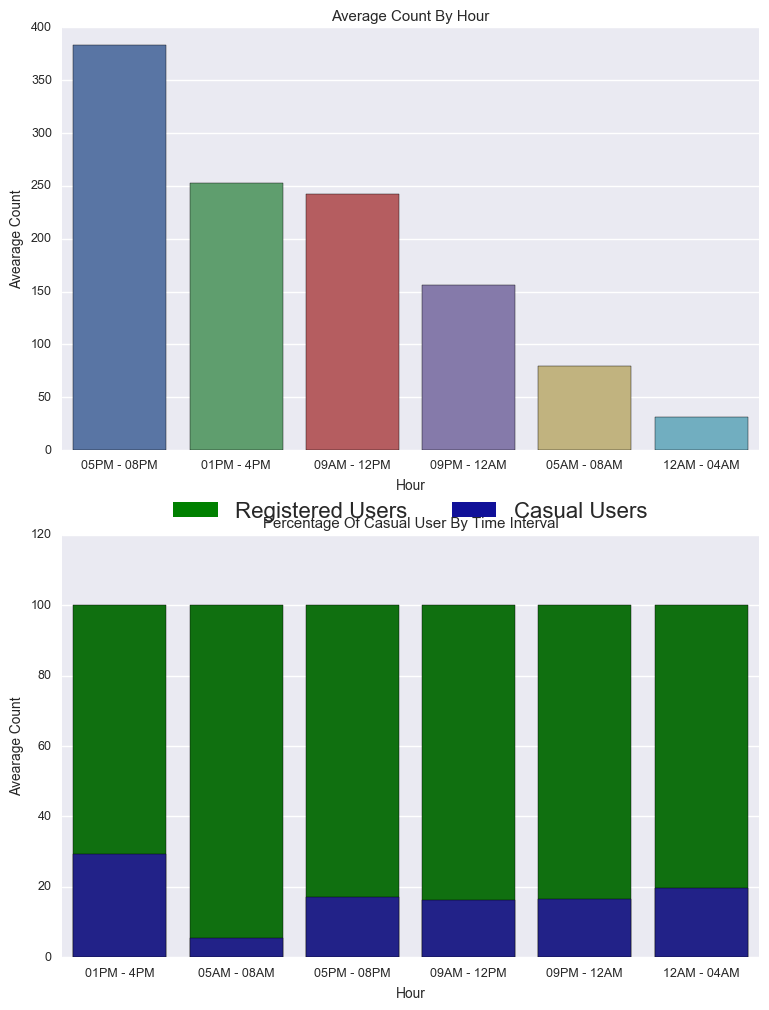

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(9, 12)

# classifying hours

dailyDataModified = data.replace({'hour' : { "00" : "12AM - 04AM", "01" : "12AM - 04AM", "02" : "12AM - 04AM" ,"03":"12AM - 04AM",
                                  "04":"05AM - 08AM","05":"05AM - 08AM","06":"05AM - 08AM","07":"05AM - 08AM",
                                  "08":"09AM - 12PM","09":"09AM - 12PM","10":"09AM - 12PM","11":"09AM - 12PM",
                                  "12":"01PM - 4PM","13":"01PM - 4PM","14":"01PM - 4PM","15":"01PM - 4PM",
                                  "16":"05PM - 08PM","17":"05PM - 08PM","18":"05PM - 08PM","19":"05PM - 08PM",
                                  "20":"09PM - 12AM","21":"09PM - 12AM","22":"09PM - 12AM","23":"09PM - 12AM"}})
dailyDataMean = pd.DataFrame(dailyDataModified.groupby("hour")["count"].mean()).reset_index().sort_values(by="count",ascending = False)
sns.barplot(data = dailyDataMean,x = "hour",y = "count",ax = ax1)
ax1.set(xlabel = 'Hour', ylabel = 'Avearage Count',title = "Average Count By Hour")


bike_week = pd.DataFrame.groupby(dailyDataModified, by = "hour", as_index = False)['casual', 'registered'].mean()
bike_week['casual_prct'] = bike_week.casual*100/(bike_week.casual + bike_week.registered)
bike_week['registered_prct'] = bike_week.registered*100/(bike_week.casual + bike_week.registered)
bike_week['total_prct'] = bike_week.casual_prct + bike_week.registered_prct
sns.set_context({"figure.figsize": (12, 4)})
sns.barplot(x = "hour", y = "total_prct", data = bike_week, color = "#008000")
sns.barplot(x = "hour", y = "casual_prct", data = bike_week, color = "#111199")
ax2.set(xlabel='Hour', ylabel='Avearage Count',title="Percentage Of Casual User By Time Interval")
green = plt.Rectangle((0,0),1,1,fc="#008000", edgecolor = 'none')
blue = plt.Rectangle((0,0),1,1,fc='#111199',  edgecolor = 'none')
legend = plt.legend([green, blue], ['Registered Users', 'Casual Users'], loc=9, ncol = 2, 
                  fancybox=True, shadow=True, prop={'size':16}, borderpad=-2)
legend.draw_frame(False)

Not surprisingly, we see the highest share of registered users during the 05AM - 08AM morning commute window. Also not surprising, the highest share of non-registered ridership happened during the 01PM - 4PM window which makes sense given tourism behaviors.